In [117]:
# Import all modules for exploratory data analysis

# Extract and save data from database
import db_utils as dbu
# Change datatype of columns to the appripriate ones
import pre_processing as prep
# Get descritve informarion from the dataframe
import extract_info as extract 
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import pandas as pd
from datetime  import datetime


In [23]:
# Extract cloud database credentials from yaml file
db_credentials = dbu.read_credentials("/Users/ChAre/OneDrive/Desktop/aicore/EDA_finance/credentials.yaml")

# Extracting the data from Amazon RDS

In [24]:
# Initialise RDSDatabaseConnector class
db_connector = dbu.RDSDatabaseConnector(db_credentials)

In [ ]:
# Connect to database and extract desire database in the cloud
# RDSDatabaseConnector.save_data() call upon: extract_data, 
db_connector.save_data()

In [25]:
# Load data into pyhton
df_unclean = db_connector.load_data("./loan_payments")

# Data preprocessing

In [ ]:
# Inspect the columns data types
df_unclean.info()

In [26]:
# Create instance of preprocessing of DataTransform class for preprocessing.
df_prep = prep.DataTransform(df_unclean)

In [27]:
# Transform columns into the categorical data type
df_prep.category_transform(["grade", "sub_grade", "home_ownership", "verification_status", "loan_status", "payment_plan", "purpose", "application_type", "employment_length", "policy_code"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,...,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,...,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,...,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,...,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


In [28]:
# Convert columns to date type data
df_prep.date_transform(["issue_date", "earliest_credit_line", "last_payment_date", "next_payment_date", "last_credit_pull_date"])

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,...,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,...,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,...,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,...,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,...,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,...,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,...,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,...,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,...,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,NaN,1,INDIVIDUAL


In [29]:
# Preporcess term column

# Convert column values into strings
df_prep.string_transform(["term"])

# Remove unwanted characters from the column values
df_prep.remove_characters("term", ["months"])

# Transform column values to numeric
df_prep.numeric_transform(["term"])

#Rename column to reflect the unit for the values
df_prep.rename_column("term", "term_in_months")

,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,NaN,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,NaN,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,NaN,NaN,1,INDIVIDUAL


In [30]:
# Create DataFrameInfo instance to extract useful information from the dataframe.
df_inf = extract.DataFrameInfo(df_prep.dataframe)

In [ ]:
# Check the data types of the columns after the transformations.
df_inf.check_columns_type()

In [ ]:
# Extract statistical values: median, standard deviation and mean from the columns
# Omitted the id and member_id columns because they are used just for identifying individuals
df_inf.descriptive_stats( ["id", "member_id"]) 

In [ ]:
# Count distinct values in categorical columns
df_inf.unique_valus_count()

In [ ]:
# Print out the shape of the DataFrame
df_inf.data_shape()

In [95]:
# Generate a count/percentage count of NULL values in each column
df_inf.count_null(percentage=True)

id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term_in_months                  8.799395
int_rate                        0.000000
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_record         88.602460
open_accounts   

Base on the percentage of missing data I decided to:
drop:
 - mths_since_last_delinq:        57.2% missing values
 - mths_since_last_record:        88.6% missing values
 - mths_since_last_major_derog    86.2% missing values

Impute:
- funded_amount                   5.5% missing values
- term_in_months                  8.8% missing values
- int_rate                        9.5% missing values
- employment_length               3.9% missing values
- last_payment_date               0.1% missing values
- last_credit_pull_date           0.013% missing values
- collections_12_mths_ex_med      0.094% missing values
- next_payment_date               86.2%  missing values

Although the next_payment_date column has 86.2% of missing values, it can be useful to project profit in the following months. Therefore I chose to impute it. I also prioritise imputing values rather than droppoing rows since it will will reduce the data in other column makeing it less reliable to impute values.

In [ ]:
# Dropping columns
df_prep.remove_columns(["mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog"])

Since most of the columns to impute have a low percentage of missing data I decide to use the mean or the median. To decide which of the two method I should use for each column I will carry a normality test for each column.

In [109]:
from scipy.stats import normaltest
def norm_test(dataframe, column):
    data = dataframe[column]
    stat, p = normaltest(data, nan_policy='omit')
    print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=4491.436, p=0.000


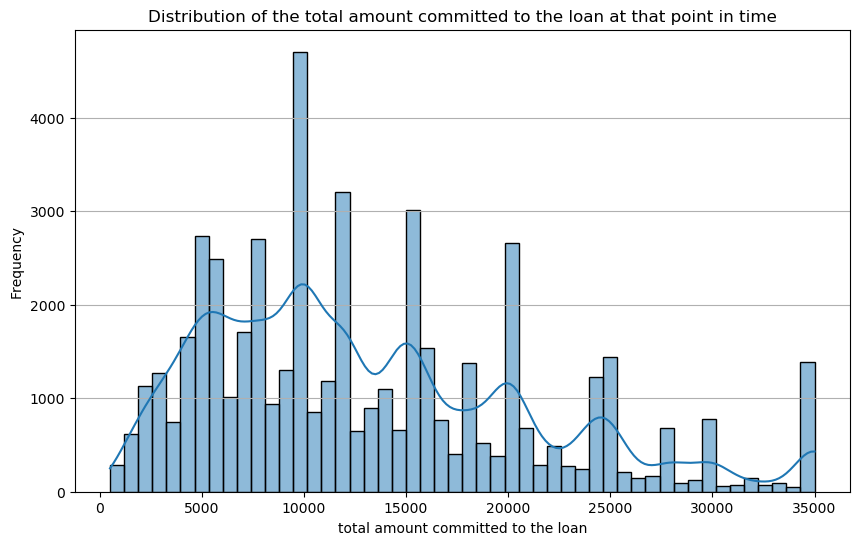

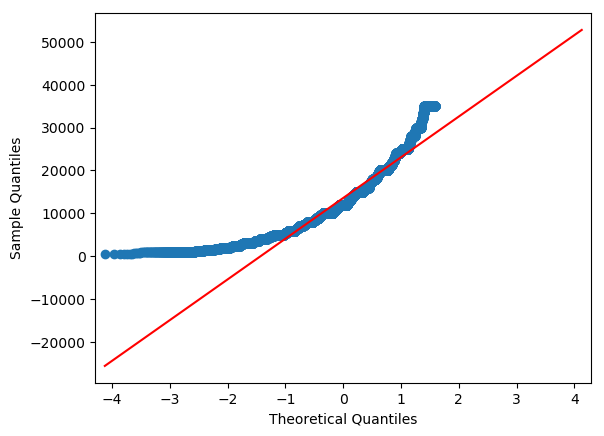

In [132]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
# Normality test
norm_test(df_prep.dataframe,"funded_amount")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="funded_amount", bins= 50, kde=True)
plt.title('Distribution of the total amount committed to the loan at that point in time.')
plt.xlabel('total amount committed to the loan')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()
# QQplot
qq_plot = qqplot(df_prep.dataframe["funded_amount"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.


In [ ]:
# Imputing "funded_amount" using the median

# Get the mendian
df_inf.descriptive_stats(selected_column=["funded_amount"])
# replace null values
df_prep.replace_null("funded_amount", 12000.0)


Statistics=16516.551, p=0.000


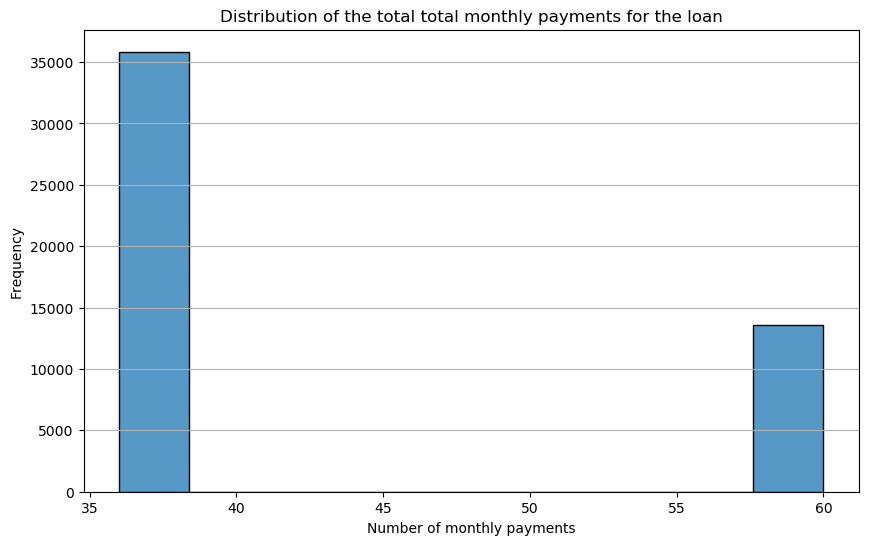

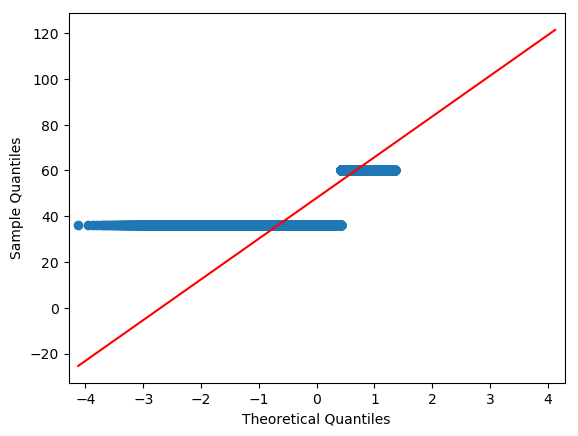

In [137]:
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
# Normality test
norm_test(df_prep.dataframe, "term_in_months")
# Historgram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="term_in_months", bins= 10)
plt.title('Distribution of the total total monthly payments for the loan')
plt.xlabel('Number of monthly payments')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

# QQplot
qq_plot = qqplot(df_prep.dataframe["term_in_months"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is only two values and since is categorical we impute the null values using the median. 

In [ ]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["term_in_months"])
# replace null values
df_prep.replace_null("term_in_months", 36.0)

In [145]:
# Normality test
norm_test(df_prep.dataframe, "int_rate")
# Historgram
df_prep.dataframe["int_rate"].hist(bins=20)
# QQplot
qq_plot = qqplot(df_prep.dataframe["int_rate"], scale=1 ,line='q')
pyplot.show()

Although the normality test had a significant p value, both histograp and QQ-plot showed that the data is skewed and therefore i will use the median.

In [34]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats(selected_column=["int_rate"])
# replace null values
df_prep.replace_null("int_rate", 13.16)


 
int_rate: 
 mean:13.507328482327546  
 median:13.16 
 standard_deviation: (4.392892583652351, 2)


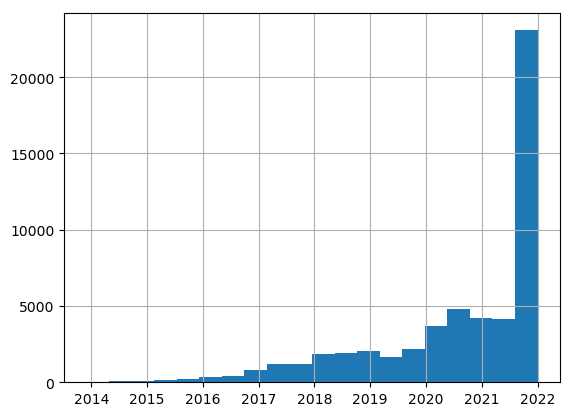

In [72]:

# Historgram
df_prep.dataframe["last_payment_date"].hist(bins=20)

The histogram showed significant skewness of the data but since the data is date type the median.

In [53]:
# Impute values of the "term_in_months" column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_payment_date"])

# replace null values
df_prep.replace_null("last_payment_date",  pd.to_datetime('2022-01-01 00:00:00'))


 
last_payment_date: 
 mean:2020-08-23 00:21:38.600391680  
 median:2021-04-01 00:00:00 
 standard_deviation: (Timedelta('586 days 05:22:10.970691976'), 2)


ValueError: No null found in the int_rate column, please choose another column.

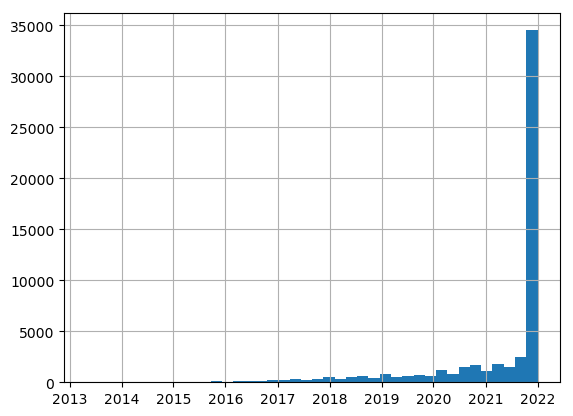

In [ ]:
#Historgram
df_prep.dataframe["last_credit_pull_date"].hist(bins=40)
plt.figure(figsize=(10, 6))
sns.histplot(data=df_prep.dataframe, x="last_credit_pull_date", bins= 5)
plt.title('Distribution of the most recent month that the loan company pulled credit for this loan')
plt.xlabel('Most recent month')
plt.ylabel('Frequency')
plt.grid(True, axis="y")
plt.show()

The histogram showed significant skewness of the data but since the data is date type the median.

In [82]:
# Impute values of the "last_payment_date column

# Get the mendian
df_inf.descriptive_stats( selected_column=["last_credit_pull_date"])

# replace null values
df_prep.replace_null("last_payment_date",  pd.to_datetime('2022-01-01 00:00:00'))


 
last_credit_pull_date: 
 mean:2021-04-15 16:16:28.964296192  
 median:2022-01-01 00:00:00 
 standard_deviation: (Timedelta('473 days 08:18:38.512651744'), 2)


ValueError: No null found in the last_payment_date column, please choose another column.

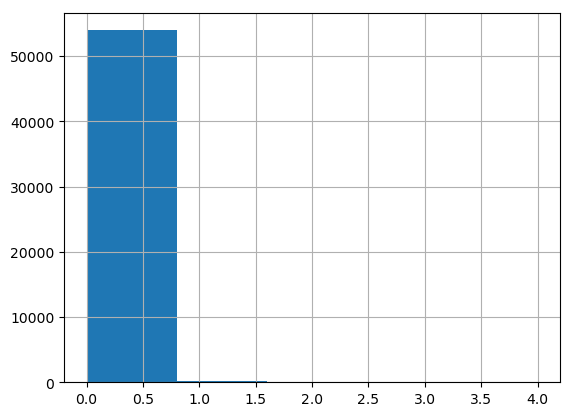

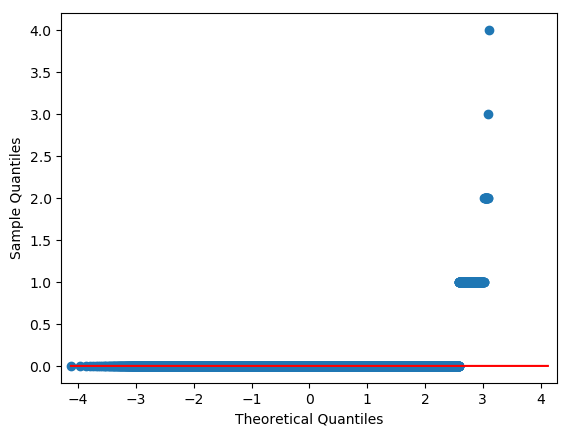

In [88]:
#Create histogram
df_prep.dataframe["collections_12_mths_ex_med"].hist(bins=5)


In [93]:
# Get the median
df_inf.descriptive_stats(selected_column=["collections_12_mths_ex_med"])
# replace null values
df_prep.replace_null("collections_12_mths_ex_med", 0.0)


 
collections_12_mths_ex_med: 
 mean:0.004208194905869324  
 median:0.0 
 standard_deviation: (0.0709901457713239, 2)


,id,member_id,loan_amount,funded_amount,funded_amount_inv,term_in_months,int_rate,instalment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,38676116,41461848,8000,8000.0,8000.0,36.0,7.49,248.82,A,A4,...,0.00,0.00,2022-01-01,248.82,2022-02-01,2022-01-01,0.0,5.0,1,INDIVIDUAL
1,38656203,41440010,13200,13200.0,13200.0,36.0,6.99,407.52,A,A3,...,0.00,0.00,2022-01-01,407.52,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
2,38656154,41439961,16000,16000.0,16000.0,36.0,7.49,497.63,A,A4,...,0.00,0.00,2021-10-01,12850.16,NaT,2021-10-01,0.0,NaN,1,INDIVIDUAL
3,38656128,41439934,15000,15000.0,15000.0,36.0,14.31,514.93,C,C4,...,0.00,0.00,2021-06-01,13899.67,NaT,2021-06-01,0.0,NaN,1,INDIVIDUAL
4,38656121,41439927,15000,15000.0,15000.0,36.0,6.03,456.54,A,A1,...,0.00,0.00,2022-01-01,456.54,2022-02-01,2022-01-01,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,76597,76583,5000,5000.0,1775.0,36.0,9.01,159.03,B,B2,...,0.00,0.00,2016-07-01,160.61,NaT,2016-07-01,0.0,NaN,1,INDIVIDUAL
54227,142608,74724,5000,5000.0,2350.0,36.0,10.59,162.73,C,C2,...,0.00,0.00,2016-10-01,490.01,NaT,2016-09-01,0.0,NaN,1,INDIVIDUAL
54228,117045,70978,3500,3500.0,2225.0,36.0,7.43,108.77,A,A2,...,0.00,0.00,2016-09-01,110.58,2016-09-01,2013-05-01,0.0,NaN,1,INDIVIDUAL
54229,88854,70699,5000,5000.0,225.0,36.0,7.43,155.38,A,A2,...,0.00,0.00,2014-03-01,0.00,NaT,2013-05-01,0.0,NaN,1,INDIVIDUAL


In [107]:
df_prep.dataframe["next_payment_date"]

0       2022-02-01
1       2022-02-01
2              NaT
3              NaT
4       2022-02-01
           ...    
54226          NaT
54227          NaT
54228   2016-09-01
54229          NaT
54230   2014-12-01
Name: next_payment_date, Length: 54231, dtype: datetime64[ns]

In [79]:
df_prep.dataframe["last_payment_date"].isnull().sum()

73

In [68]:
df_inf.dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           54231 non-null  int64         
 1   member_id                    54231 non-null  int64         
 2   loan_amount                  54231 non-null  int64         
 3   funded_amount                51224 non-null  float64       
 4   funded_amount_inv            54231 non-null  float64       
 5   term_in_months               49459 non-null  float64       
 6   int_rate                     54231 non-null  object        
 7   instalment                   54231 non-null  float64       
 8   grade                        54231 non-null  category      
 9   sub_grade                    54231 non-null  category      
 10  employment_length            52113 non-null  category      
 11  home_ownership               54231 non-nu